### such a shame

In [1]:
class Student(object):
    def __init__(self, name, score):
        self.namm = name
        self.score = score

    def print_score(self):
        print('%s: %s' % (self.namm, self.score))
    
    def shoutout(self):
        print("Oh NO!!!")
Jade = Student('Jader', 59)
Jade.print_score()
Jade.shoutout()

Jader: 59
Oh NO!!!


In [194]:
import numpy as np

def normalize_1(matrix):
    """
    归一化矩阵：将矩阵的每一行除以该行的第一列值。
    """
    matrix = np.array(matrix, dtype=float)  # 确保是 NumPy 数组，并转换为浮点数
    return matrix[:, 1:] / matrix[:, 0][:, np.newaxis]  # 每行除以第一列的值

def row_sums(matrix):
    """
    计算矩阵的行和。
    """
    matrix = np.array(matrix, dtype=float)
    return np.sum(matrix, axis=1)  # 按行求和

def zero_if_positive(matrix):
    """
    将正数归0，用于库存大于0时停止生产
    """
    matrix = np.array(matrix, dtype=float)
    matrix[matrix > 0] = 0  # Set elements greater than 1 to zero
    return matrix

class Block1(object): 
    def __init__(self, n, csp, p_t, itl, sts, wts, tps):
        """
        经济模拟系统中的区块（Block1）类。
        
        参数：
        - n: 区块中职业种类数
        - csp: 消费矩阵（职业数量 × 商品种类），表示各职业人口的商品消耗量
        - p_t: 生产时间矩阵（职业数量 × 商品种类），表示生产一单位商品所需时间
        - itl: 商品缺乏耐受度矩阵（职业数量 × 商品种类）
        - sts: 状态张量（时间 × 职业数量 × 商品种类），表示库存状态
        - wts: 工作时间张量（时间 × 职业数量 × 商品种类），表示每日生产所花费的时间
        - tps: 商品基准价格列表
        """
        self.n = n  # 区块中职业数量
        
        # 确保所有矩阵数据都是 NumPy 数组
        self.consumption = np.array(csp, dtype=float)  # 商品消耗量
        self.product_time = np.array(p_t, dtype=float)  # 生产单位商品所需时间
        self.intolerance = np.array(itl, dtype=float)  # 缺乏商品的耐受度
        
        # 计算可承受的最高买入价格/最低卖出价
        self.aff_price = normalize_1(self.product_time)  
        
        # 状态和工作时间存储为张量（时间序列）
        self.status = [np.array(st, dtype=float) for st in sts]  # 库存状态序列
        self.worktimes = [np.array(wt, dtype=float) for wt in wts]  # 工作时间序列
        
        # 贸易价格存储为 NumPy 数组（基准价格）
        self.trade_prices = np.array(tps, dtype=float)
        
        # 交易记录
        self.exchanges = []
#         self.
    
    def evolution(self, k):
        """
        经济演化过程。
        
        参数：
        - k: 贸易依存度（0 = 无贸易，1 = 完全依赖贸易）
        """
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度）
        self.worktimes.append(-zero_if_positive(self.status[-1]) * self.intolerance)
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktimes[-1] / self.product_time
        
        # 计算总劳动负担（每个职业的工作时间总和）
        loading = row_sums(self.worktimes[-1])
        
        # 计算商品价格（受劳动负担影响): 一个人工作的时间越长，他就越愿意支付更高的价格来减轻自己的负担
        # 因此，需要按每个人的工作负荷时间进行加权
        if np.sum(loading) != 0:
            self.trade_prices = np.append(self.trade_prices, 
                                         [np.dot(loading, self.aff_price) / (np.sum(loading) + 0.001)], axis=0)
        else:
            self.trade_prices = np.append(self.trade_prices, [self.trade_prices[-1]], axis=0)
        
        ## 计算贸易量变化
        # 商品价格差（对出手的渴望程度） = 商品价格 - 可承受价格
        print(self.trade_prices[-1],self.aff_price[0])
        desire = self.trade_prices[-1] - self.aff_price[0]
        # 贸易易方向， 渴望出手时卖出，不想出手时买入
        direction = np.sign(desire)
        #初始化贸易量
        change = np.zeros(len(self.status[0][0]))
        for i in range(len(self.aff_price[0])):   
            if self.trade_prices[-1][i] < 1:
                change[0] = change[0] + self.trade_prices[-1][i] * k * direction[i]
                change[i+1] = -k * direction[i]
            else:
                change[0] = change[0] + k * direction[i]
                change[i+1] = -1 / self.trade_prices[-1][i] * k * direction[i]
        
        # 记录交易变化
        self.exchanges.append([change, -change])
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
       # print(production,self.consumption, self.exchanges[-1])
        newstatus = self.status[-1] + production - self.consumption + self.exchanges[-1]
        
        # 记录新的库存状态
        self.status.append(np.round(newstatus, 2))

In [195]:
couple = Block1(2, 
               [[1, 1, 1], [1, 1, 1]], 
               [[0.4, 0.1, 0.3], [0.2, 0.5,0.2]], 
               [[0.2, 0.05, 0.1], [0.2, 0.05, 0.1]], 
               [[[0, 0, 0], [0, 0, 0]]], 
               [[[0, 0, 0], [0, 0, 0]]], 
               [[1,1]])
couple.aff_price

array([[0.25, 0.75],
       [2.5 , 1.  ]])

In [199]:
couple.evolution(1)

[1.52539794 0.89103464] [0.25 0.75]


In [189]:
np.dot(np.array([0.1605,0.5485]),[[0.4],
 [1.66666667]])

array([0.97836667])

In [153]:
# 创建实例
couple = Block1(2, 
               [[1, 1], [1, 1]], 
               [[0.5, 0.2],[0.3, 0.5]], 
               [[0.2, 0.05], [0.2, 0.05]], 
               [[[0, 0], [0, 0]]], 
               [[[0, 0], [0, 0]]], 
               [[1]])

couple = Block1(2, 
               [[1, 1, 1], [1, 1, 1]], 
               [[0.4, 0.1, 0.3], [0.2, 0.5,0.2]], 
               [[0.2, 0.05, 0.1], [0.2, 0.05, 0.1]], 
               [[[0, 0, 0], [0, 0, 0]]], 
               [[[0, 0, 0], [0, 0, 0]]], 
               [[1,1]])

for i in range(40):
    couple.evolution(1)
for i in range(60):
    couple.evolution(1)
couple.trade_prices[-1]

array([1.30806617, 0.86707026])

In [152]:
couple.worktimes[-4]

array([[-0.    ,  0.2   ,  0.599 ],
       [ 0.566 ,  0.0015, -0.    ]])

In [82]:
couple.product_time

array([[0.4 , 0.1 , 0.3 ],
       [0.2 , 0.4 , 0.15]])

In [96]:
couple.aff_price

array([[0.25],
       [2.  ]])

In [102]:
np.sign(5)

1

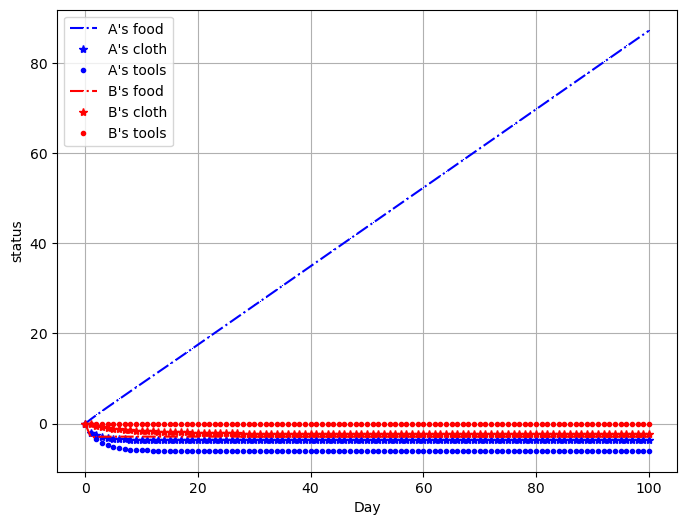

In [154]:
import matplotlib.pyplot as plt
names = ["A's ", "B's "];
goods = ["food", "cloth", "tools"];
lines = ["-.,","*","."]
colors = ["blue", "red", "green"];
final = couple.status
plt.figure(figsize=(8, 6))
x=range(0,len(final))
def fun_fianl(x,i,j):
    return [final[y][i][j] for y in x]
# plt.gca().set_aspect('equal')
for i in range(len(final[0])):
    for j in range(len(final[0][1])):
        plt.plot(x, fun_fianl(x,i,j), lines[j], color = colors[i], label = names[i]+goods[j])
plt.xlabel('Day')
plt.ylabel('status')
plt.legend(loc='best')
plt.grid()
plt.show()

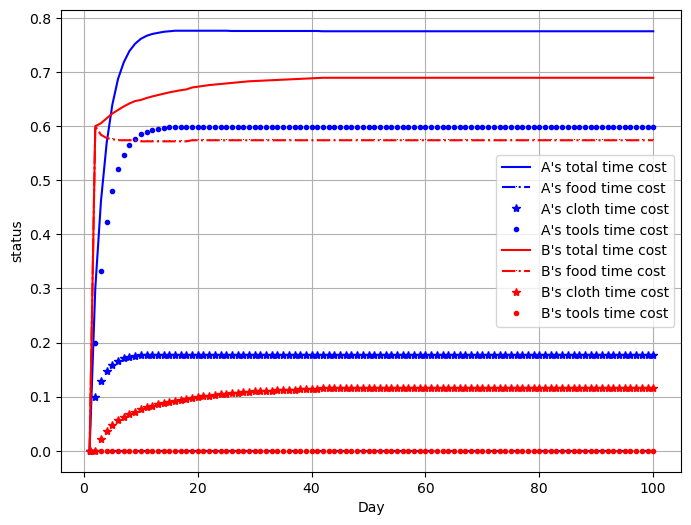

In [155]:
plt.figure(figsize=(8, 6))
worktimes = couple.worktimes;
loadings = [row_sums(i) for i in worktimes]
x=range(1,len(worktimes))
# plt.gca().set_aspect('equal')
for i in range(len(worktimes[0])):
    plt.plot(x, np.array(loadings)[x,i],colors[i],label = names[i]+"total time cost")
    for j in range(len(worktimes[0][1])):
        plt.plot(x, np.array(worktimes)[x,i,j], lines[j], color = colors[i], label = names[i]+goods[j]+" time cost")
plt.xlabel('Day')
plt.ylabel('status')
plt.legend(loc='best')
plt.grid()
plt.show()